In [2]:
%matplotlib inline

In [3]:
import cv2
import numpy as np
import joblib
import os
import sklearn
import random
import matplotlib.pyplot as plt
import skimage.measure
from sklearn.svm import LinearSVC
import skimage.util
import sklearn.datasets
import sklearn.metrics
import sklearn.neighbors
import sklearn.svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets, neighbors

In [4]:
plt.rcParams['figure.figsize'] = 12, 8

# Extract hand written digits from an image

In [5]:
digits_rgb = cv2.imread('data/20181129_090521.jpg')[..., ::-1]
digits_rgb = cv2.resize(digits_rgb, (800, 600))

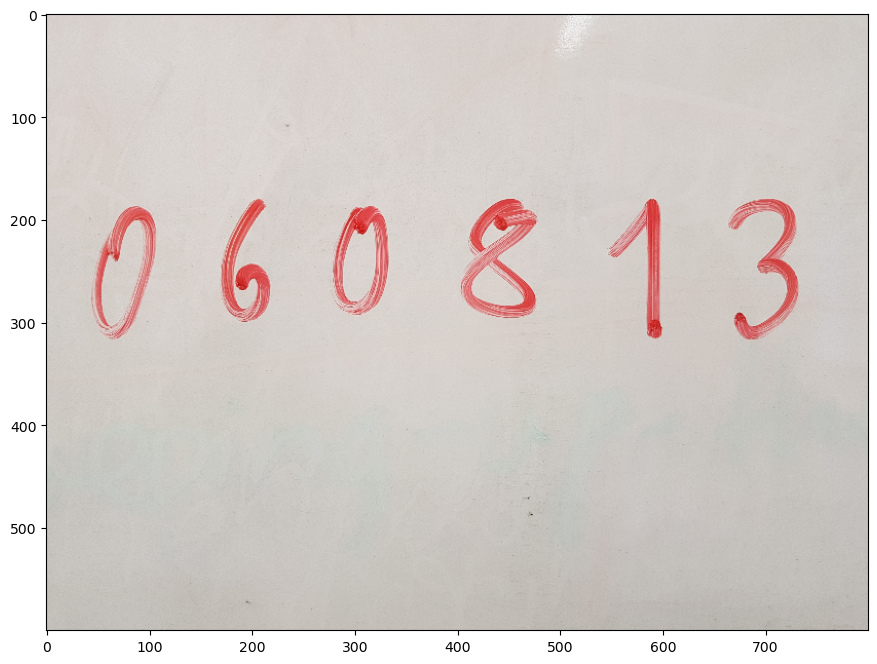

In [6]:
plt.imshow(digits_rgb);
# plt.show();

In [7]:
# enhance and extract the red component
# digits_r = digits_rgb[..., 0] / (digits_rgb[..., 0] + digits_rgb[..., 1] + digits_rgb[..., 2])  # uint8 overflow
digits_r = digits_rgb[..., 0] / digits_rgb.sum(axis=2)
# digits_r = 255 - digits_rgb[..., 1]  # also works
digits_r = np.uint8(255 * digits_r)

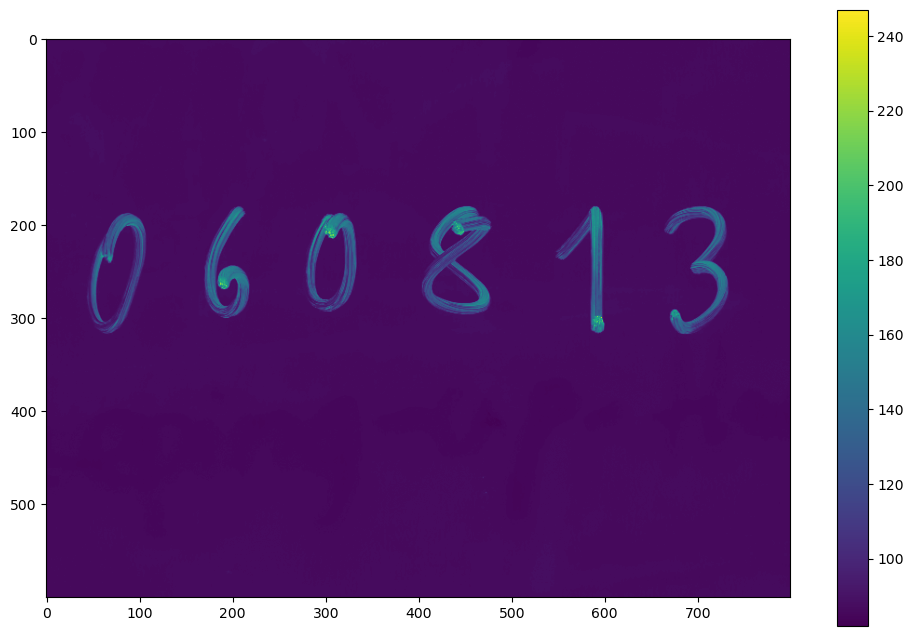

In [8]:
plt.imshow(digits_r)
plt.colorbar();

In [9]:
digits_thresh_val, _ = cv2.threshold(digits_r, 0, 255, cv2.THRESH_OTSU)
digits_thresh_val

110.0

In [10]:
digits_thresholded = digits_r > digits_thresh_val - 20
digits_thresholded = np.uint8(255 * digits_thresholded)

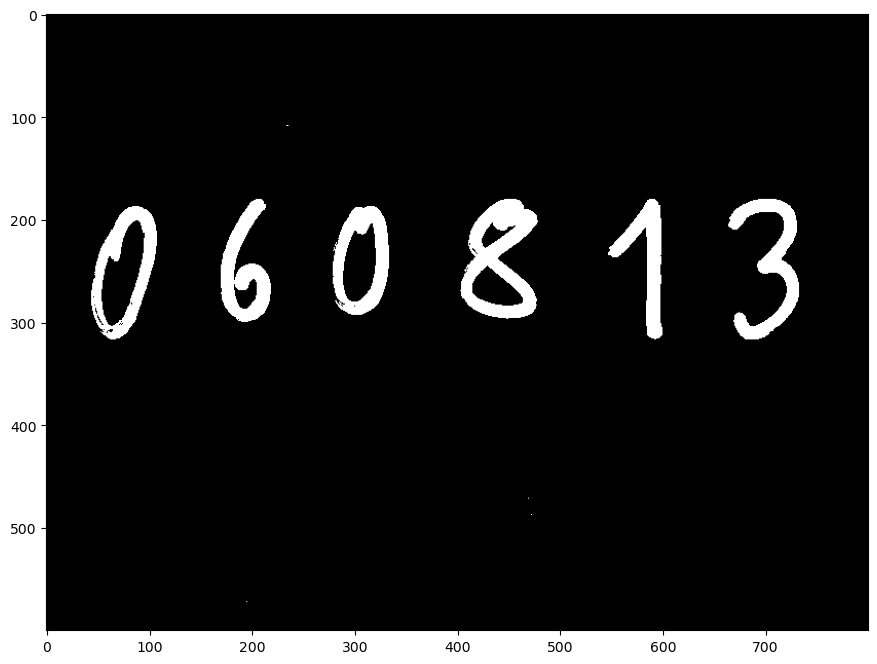

In [11]:
plt.imshow(digits_thresholded, cmap='gray');

In [12]:
digits_opened = cv2.morphologyEx(
    digits_thresholded,
    cv2.MORPH_OPEN,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)

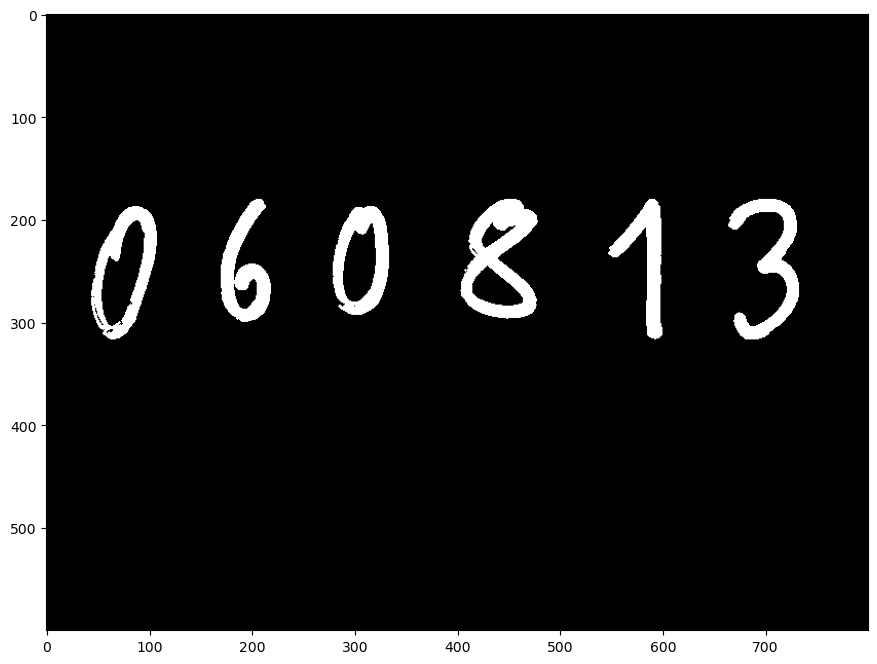

In [13]:
plt.imshow(digits_opened, cmap='gray');

In [14]:
digits_closed = cv2.morphologyEx(
    digits_opened,
    cv2.MORPH_CLOSE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)

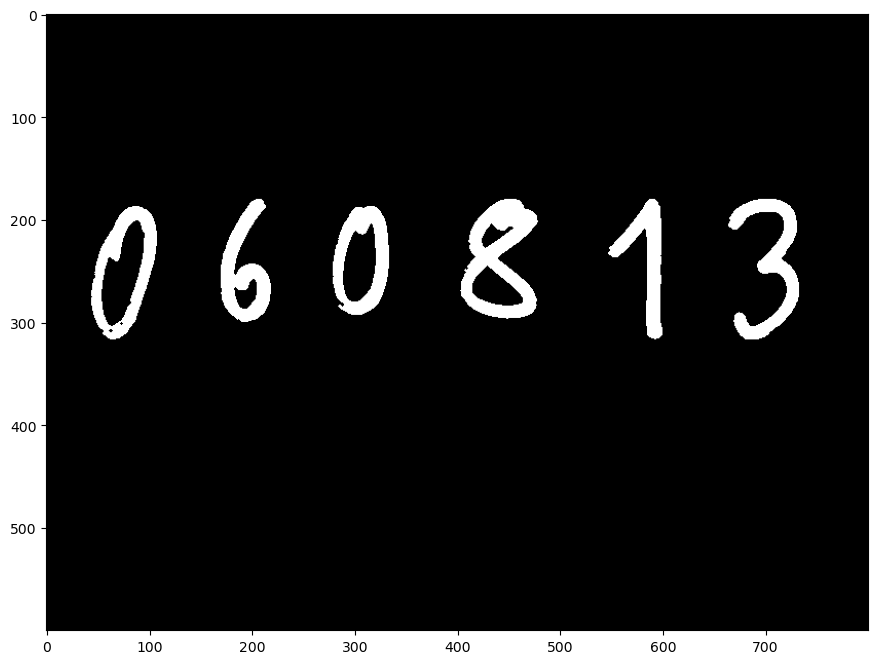

In [15]:
plt.imshow(digits_closed, cmap='gray');

In [16]:
digits_contours, digits_hierarchy = cv2.findContours(digits_closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
len(digits_contours)

13

`cv2.findContours` outputs not only the boundaries of objects, but also their hierarchy. In other words, it tells us which contours are inside which in case there are holes in some of them (holes have their contours too).

In [17]:
digits_hierarchy

array([[[ 2, -1,  1, -1],
        [-1, -1, -1,  0],
        [ 6,  0,  3, -1],
        [ 4, -1, -1,  2],
        [ 5,  3, -1,  2],
        [-1,  4, -1,  2],
        [ 7,  2, -1, -1],
        [ 8,  6, -1, -1],
        [11,  7,  9, -1],
        [10, -1, -1,  8],
        [-1,  9, -1,  8],
        [-1,  8, 12, -1],
        [-1, -1, -1, 11]]], dtype=int32)

The last column specifies index of the parent and when it is `-1`, there is no parent.

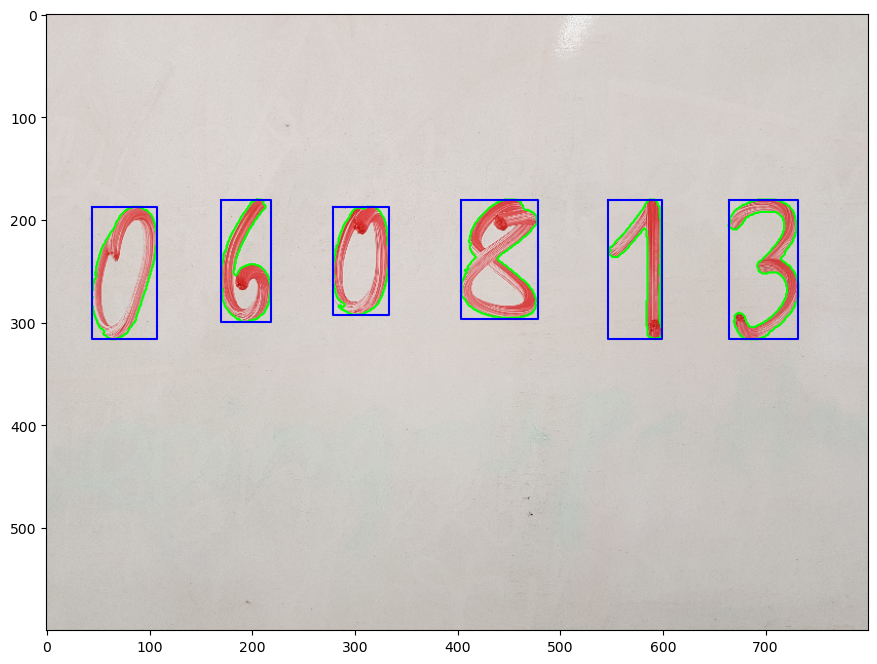

In [18]:
plt.imshow(digits_rgb)

digits = []
for i, c in enumerate(digits_contours):
    # we only want outer contours
    if digits_hierarchy[0, i, 3] > -1:
        continue
    
    # plot the contour
    plt.plot(c[:, 0, 0], c[:, 0, 1], color=(0, 1, 0))
    
    # bounding box
    l, r = c[:, 0, 0].min(), c[:, 0, 0].max()
    t, b = c[:, 0, 1].min(), c[:, 0, 1].max()
    plt.plot([l, r, r, l, l], [t, t, b, b, t], color=(0, 0, 1))
    
    # extract (cut) the digit region from the image
    digits.append(digits_closed[t:b+1, l:r+1])

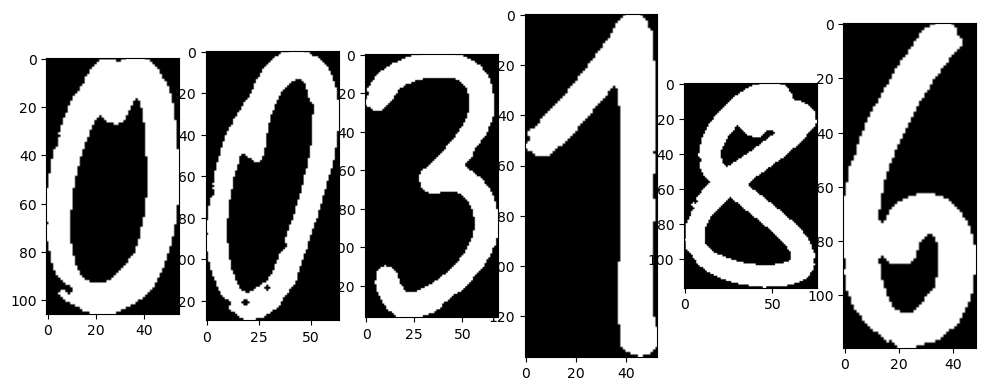

In [19]:
for i, d in enumerate(digits):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(d, cmap='gray')

# Classification by comparing pixel values

In [20]:
# must normalize to the same size before we can compare pixel-by-pixel
target_size = 50, 100  # width, height
digits = [cv2.resize(d, target_size).astype(float) / 255. for d in digits]

In [21]:
#for i, d in enumerate(digits_rois):
    #plt.subplot(1, len(digits_rois), i + 1)
    #plt.imshow(d, cmap='gray')

In [22]:
# let's say the first digit is unknown
query = digits[0]

In [23]:
# compute euclidean distances from the query to each digit
digits_dists = np.array([np.sum((query - d) ** 2) for d in digits])
digits_dists

array([   0.        , 1151.74589773, 1779.7197078 , 1558.92928874,
       1723.1706882 , 1741.13268743])

In [24]:
# argsort will give us order of the images when compared by their distance to the query
digits_rank = np.argsort(digits_dists)
digits_rank

array([0, 1, 3, 4, 5, 2], dtype=int64)

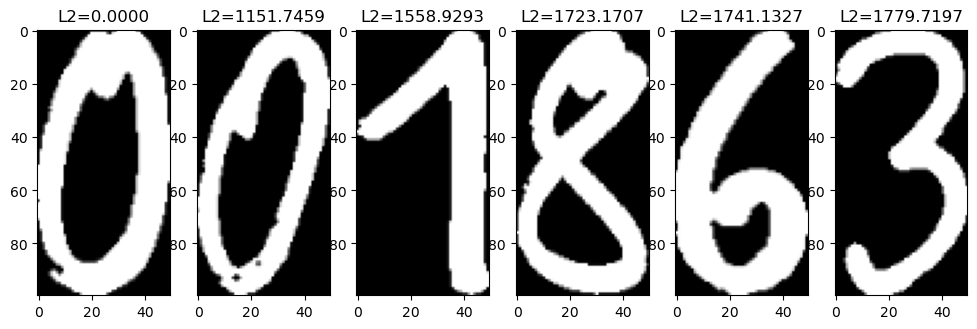

In [25]:
for i, j in enumerate(digits_rank):
    plt.subplot(1, len(digits), i + 1)
    plt.imshow(digits[j], cmap='gray')
    plt.title(f'L2={digits_dists[j]:.4f}')

# Compare all the digits to templates in `20181129_090518.jpg`

In [26]:
template_rgb = cv2.imread('data/20181129_090518.jpg')[..., ::-1]
template_rgb = cv2.resize(template_rgb, (800, 600))

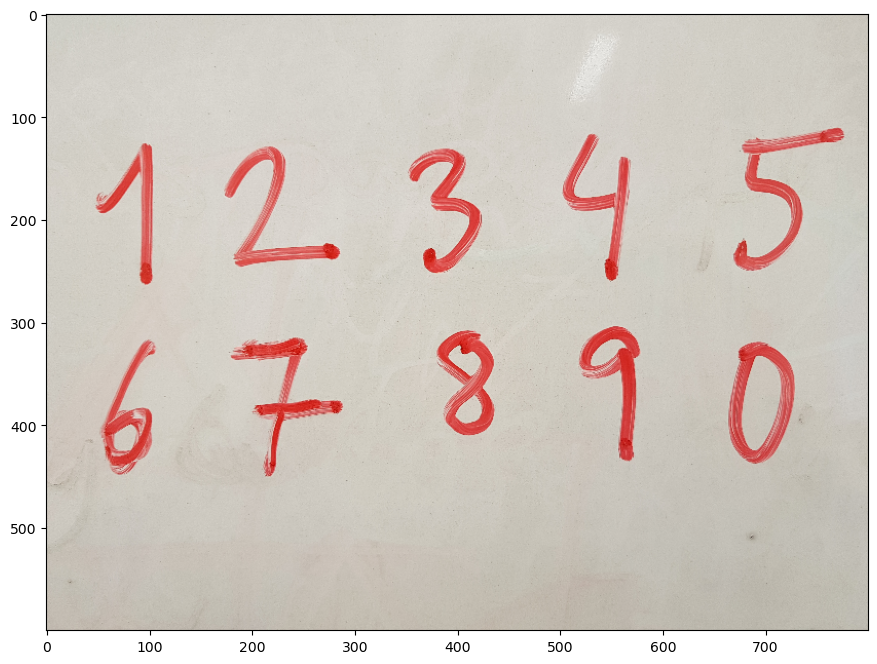

In [27]:
plt.imshow(template_rgb);

Repeat the same preprocessing & extraction procedure for templates. Better way would be to refactor the preprocessing into a function.

In [28]:
# red channel enhancement
template_r = np.uint8(255. * template_rgb[..., 0] / template_rgb.sum(axis=2))

# thresholding using previously determined threshold value
template_thresholded = 255 * np.uint8(template_r > digits_thresh_val - 20)

# morphology
template_opened = cv2.morphologyEx(
    template_thresholded,
    cv2.MORPH_OPEN,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)
template_closed = cv2.morphologyEx(
    template_opened,
    cv2.MORPH_CLOSE,
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)

# find contours
template_contours, template_hierarchy = cv2.findContours(template_closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

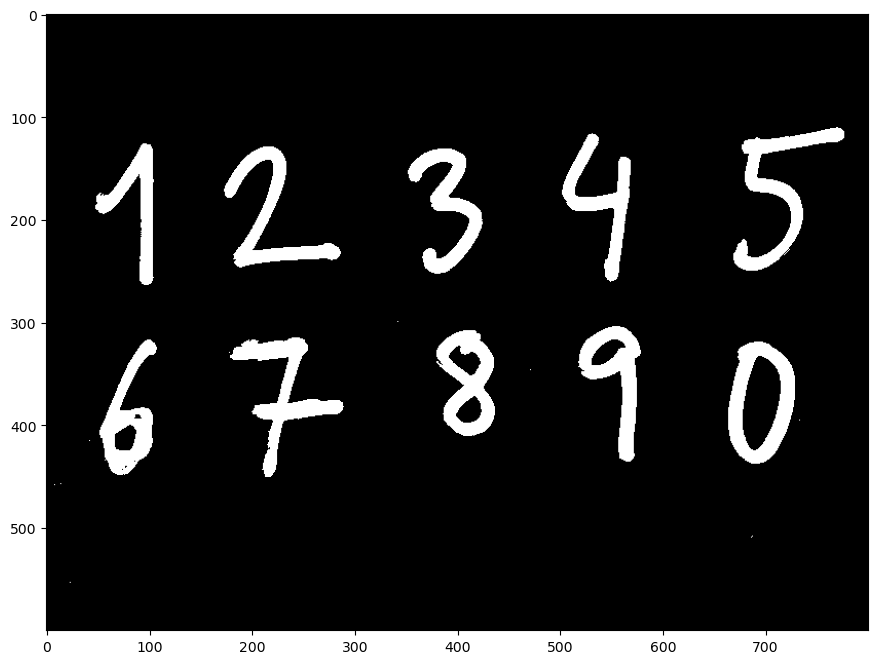

In [29]:
plt.imshow(template_thresholded, cmap='gray');

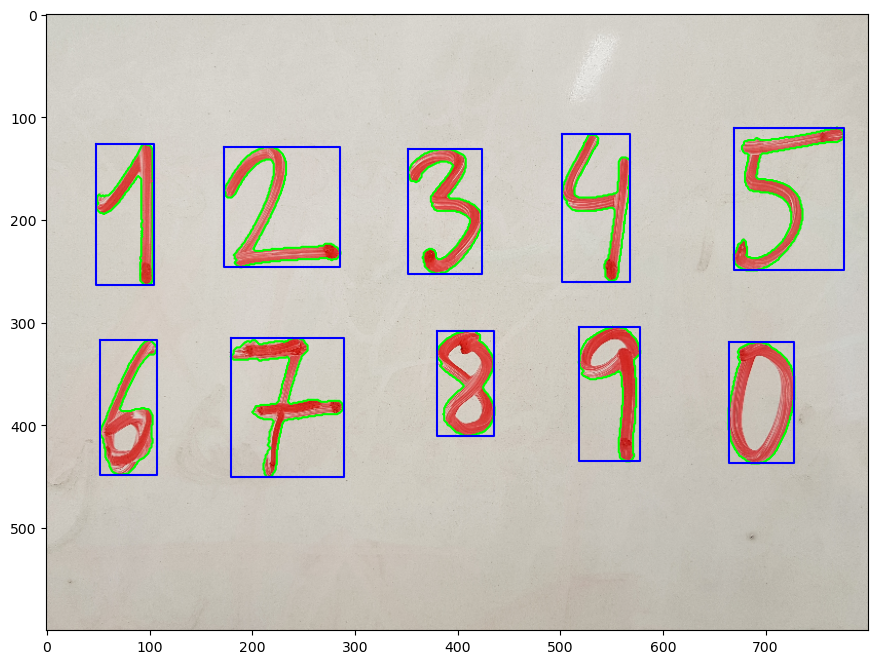

In [30]:
plt.imshow(template_rgb)

templates = []
for i, c in enumerate(template_contours):
    # we only want outer contours
    if template_hierarchy[0, i, 3] > -1:
        continue
    
    # plot the contour
    plt.plot(c[:, 0, 0], c[:, 0, 1], color=(0, 1, 0))
    
    # bounding box
    l, r = c[:, 0, 0].min(), c[:, 0, 0].max()
    t, b = c[:, 0, 1].min(), c[:, 0, 1].max()
    plt.plot([l, r, r, l, l], [t, t, b, b, t], color=(0, 0, 1))
    
    # extract (cut) the digit region from the image and resize
    templates.append(cv2.resize(template_closed[t:b+1, l:r+1], target_size) / 255.)

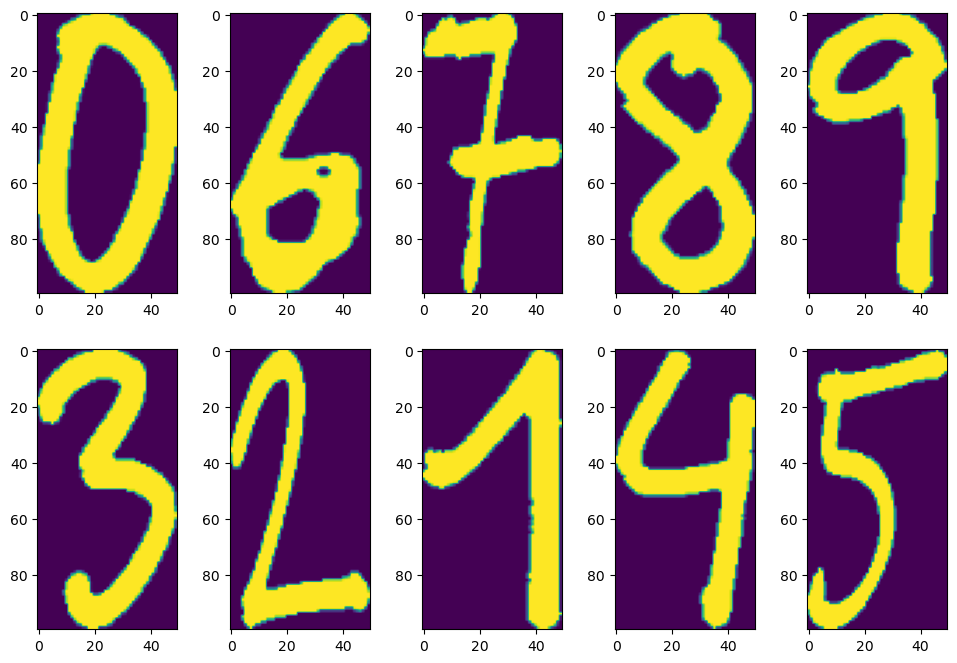

In [31]:
for i, d in enumerate(templates):
    plt.subplot(2, len(templates) // 2, i + 1)
    plt.imshow(d)

In [32]:
template_dists = np.array([
    [np.sum((d - t) ** 2) for t in templates]
    for d in digits
])
template_dists.dtype, template_dists.shape, template_dists.min(), template_dists.max()

(dtype('float64'), (6, 10), 634.0007381776239, 2692.8469050365247)

In [33]:
template_rank = np.argsort(template_dists, axis=1)
template_rank

array([[0, 8, 4, 7, 3, 5, 1, 6, 9, 2],
       [0, 1, 7, 4, 8, 9, 6, 5, 2, 3],
       [5, 4, 8, 2, 0, 6, 3, 9, 7, 1],
       [7, 4, 8, 0, 3, 5, 1, 9, 6, 2],
       [3, 1, 0, 9, 4, 8, 6, 7, 2, 5],
       [1, 3, 0, 6, 7, 9, 5, 2, 8, 4]], dtype=int64)

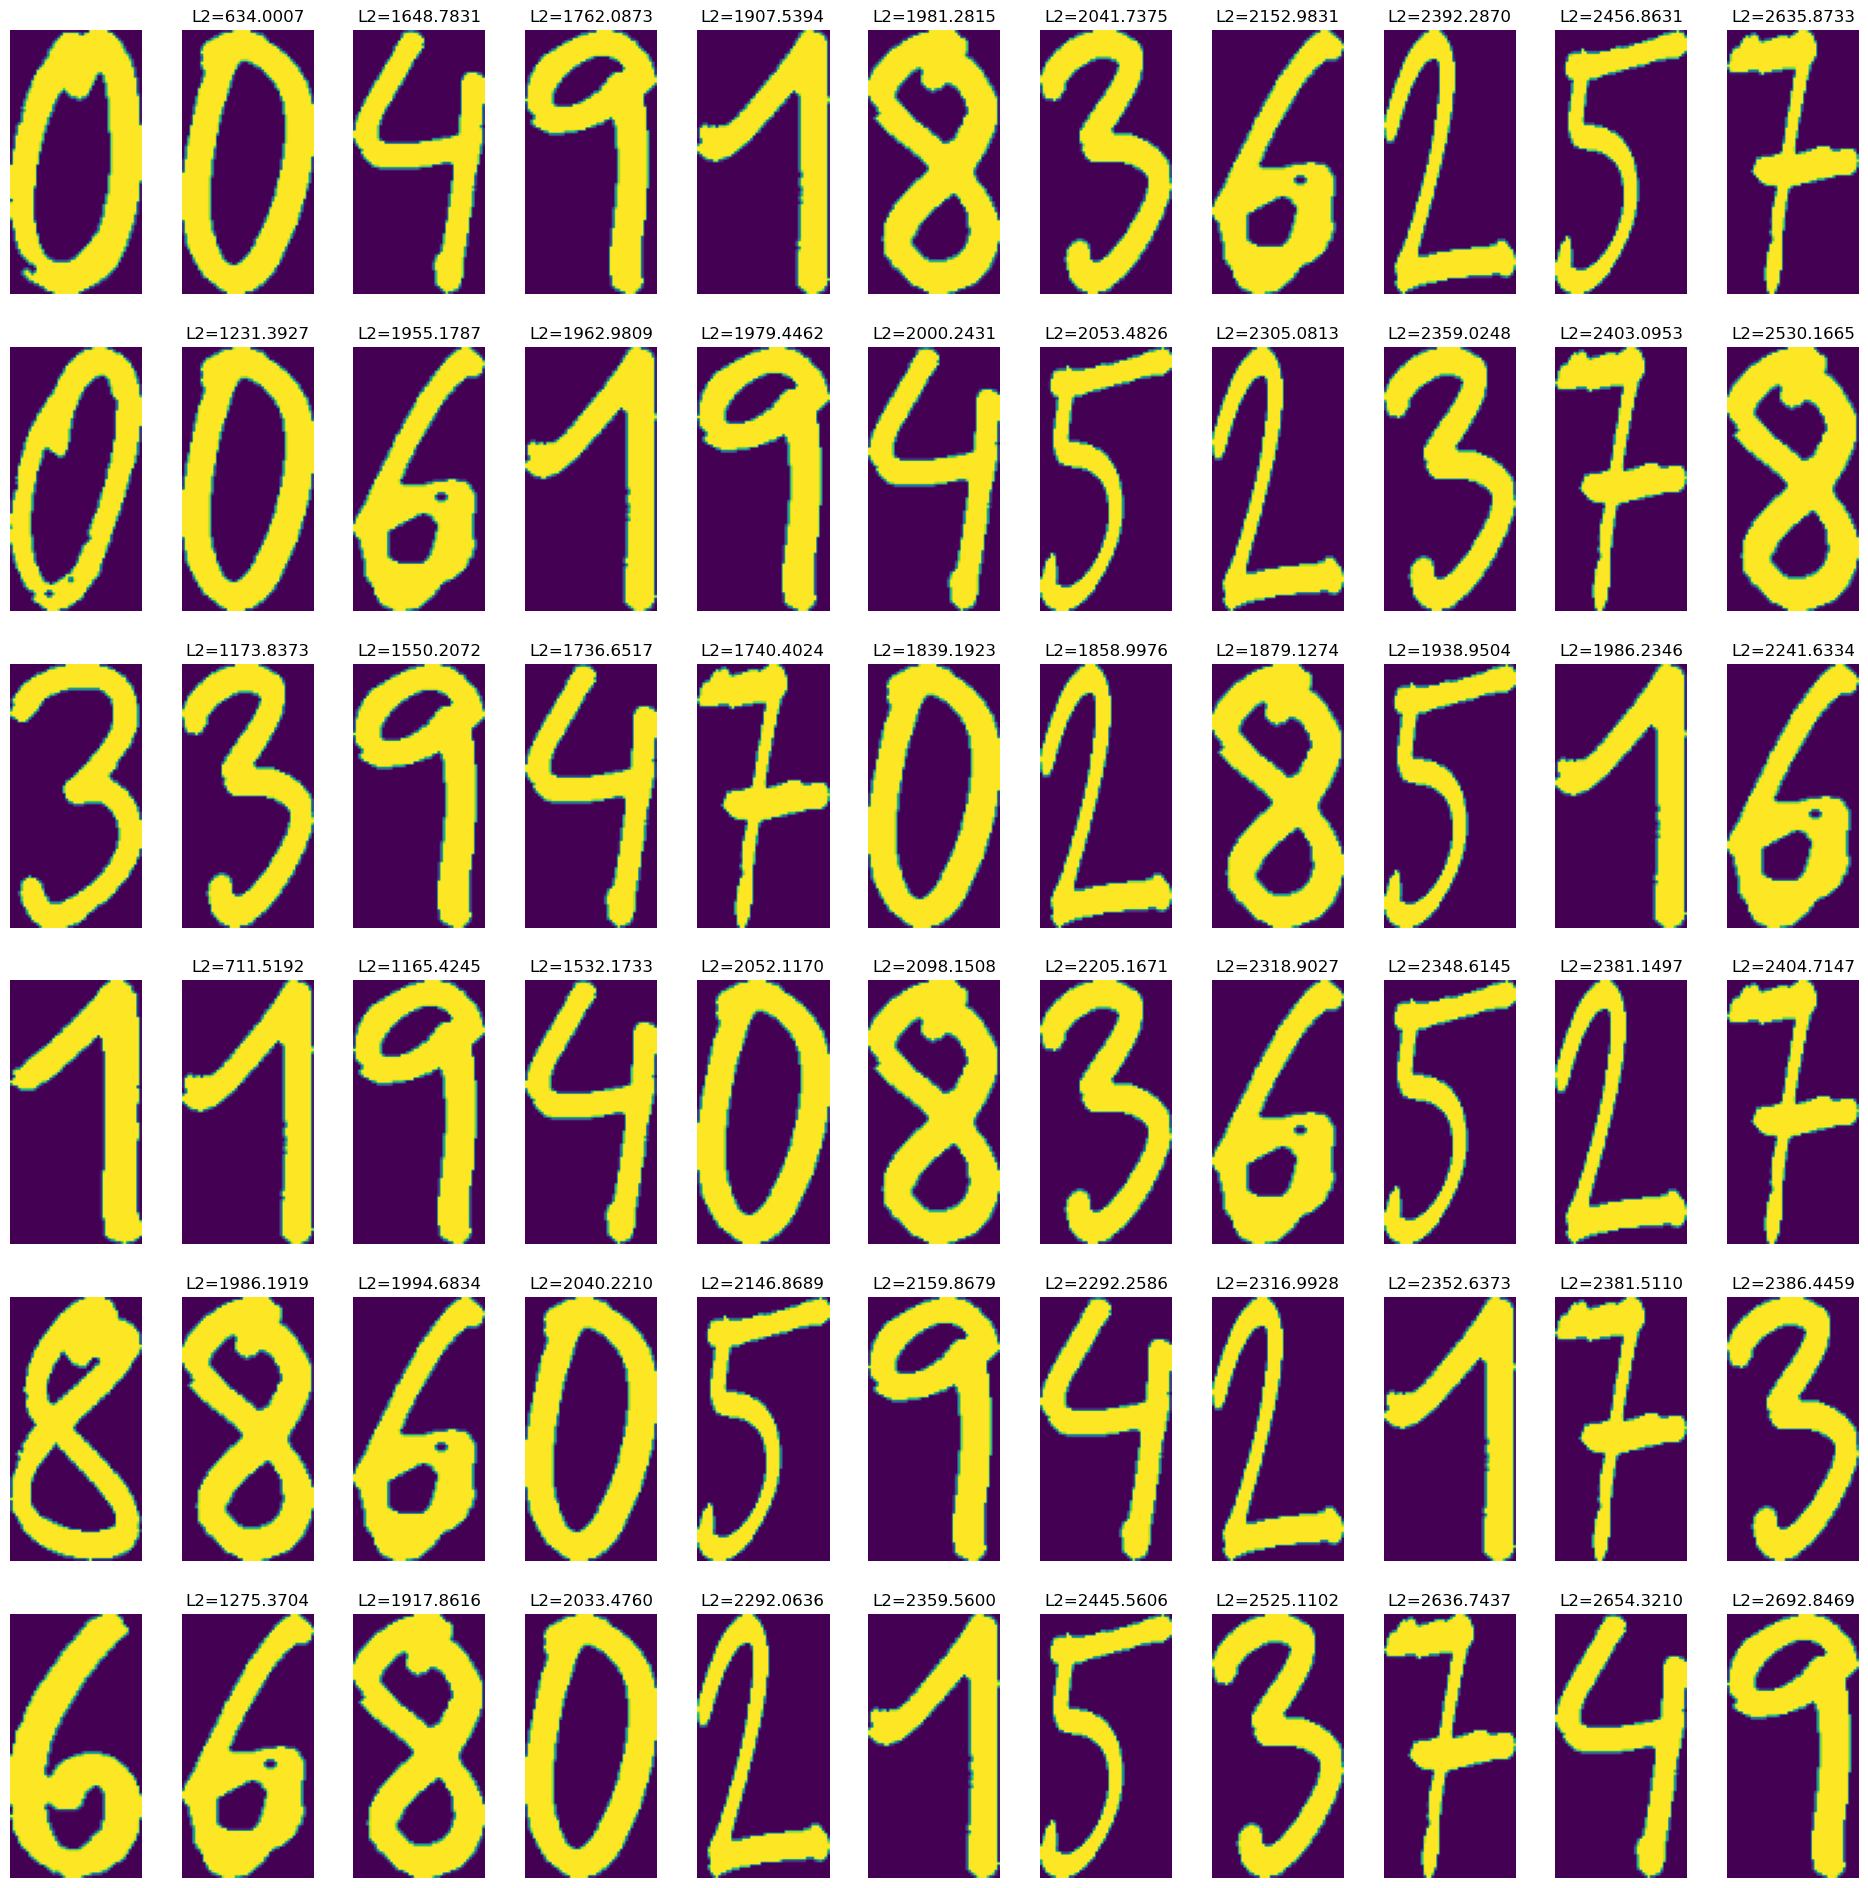

In [34]:
plt.figure(figsize=(24, 24))

for i in range(len(digits)):
    plt.subplot(len(digits), 1 + len(templates), i * (1 + len(templates)) + 1)
    plt.imshow(digits[i])
    plt.axis('off')
    
    for j, k in enumerate(template_rank[i, :]):
        plt.subplot(len(digits), 1 + len(templates), i * (1 + len(templates)) + j + 2)
        plt.imshow(templates[k])
        plt.title(f'L2={template_dists[i, k]:.4f}')
        plt.axis('off')

# Nearest neighbor classifier in `sklearn`

In [35]:
X_train = np.array(templates).reshape(len(templates), -1)
X_train.dtype, X_train.shape, X_train.min(), X_train.max()

(dtype('float64'), (10, 5000), 0.0, 1.0)

In [36]:
y_train = np.array([0, 6, 7, 8, 9, 3, 2, 1, 4, 5])
y_train.dtype, y_train.shape

(dtype('int32'), (10,))

In [37]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, algorithm='brute')
knn

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

In [38]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

In [39]:
X_valid = np.array(digits).reshape(len(digits), -1)
X_valid.dtype, X_valid.shape, X_valid.min(), X_valid.max()

(dtype('float64'), (6, 5000), 0.0, 1.0)

In [40]:
y_valid = np.array([0, 6, 7, 8, 9, 3, 2, 1, 4, 5])
y_valid.dtype, y_valid.shape

(dtype('int32'), (10,))

In [41]:
y_pred = knn.predict(X_valid)
y_pred

array([0, 0, 3, 1, 8, 6])

In [42]:
# calculate accuracy
np.sum(y_pred == y_valid) / len(y_valid)

C:\Users\ANOOP\AppData\Local\Temp\ipykernel_12720\2927836170.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.sum(y_pred == y_valid) / len(y_valid)


0.0

# Task 1: Use a larger dataset and train K-NN and SVM classifiers

In [43]:
# there might be some issuses depending on the version of sklearn (1.0.1 is recommended)
sklearn.__version__

'1.3.0'

In [44]:
# download the dataset
data = sklearn.datasets.fetch_openml(name='mnist_784')
data.keys()

C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [45]:
# make everything compatible with older versions (new version return pandas DataFrame)
X_train = data['data'] if isinstance(data['data'], np.ndarray) else data['data'].to_numpy()
y_train = data['target'] if isinstance(data['target'], np.ndarray) else data['target'].to_numpy().astype(int)

In [46]:
# target size needs to be set to the same size as training data
mnist_target_shape = 28, 28

In [47]:
X_train.dtype, X_train.shape, X_train.min(), X_train.max()

(dtype('float64'), (70000, 784), 0.0, 255.0)

In [48]:
y_train.dtype, y_train.shape, y_train.min(), y_train.max()

(dtype('int32'), (70000,), 0, 9)

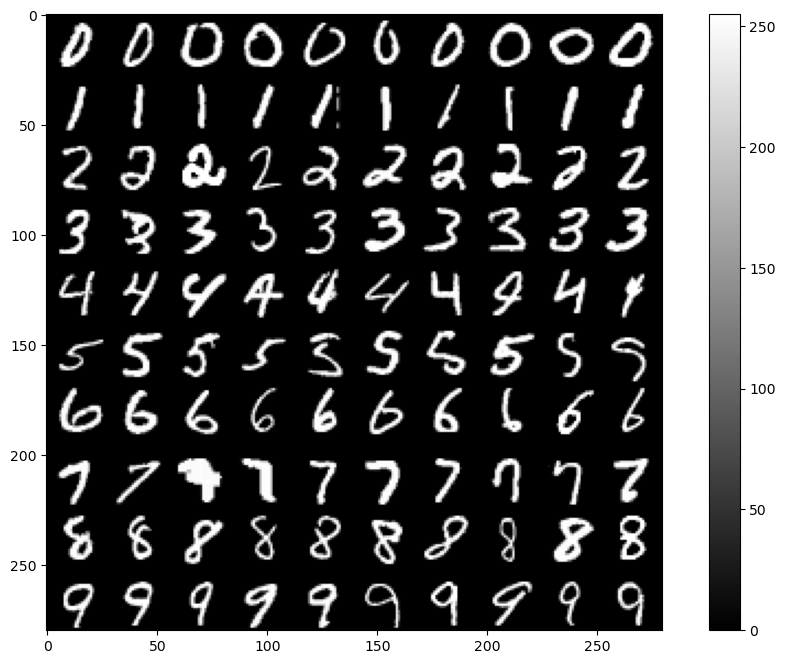

In [49]:
# draw randomly chosen samples from the MNIST dataset
plt.imshow(
    skimage.util.montage(
        np.concatenate([
            np.random.default_rng().choice(X_train[y_train==i], size=10, replace=False).reshape(-1, *mnist_target_shape)
            for i in range(10)
        ])
    ),
    cmap='gray'
)
plt.colorbar();

In [50]:
# create the KNN classifier object
knn = neighbors.KNeighborsClassifier()
knn

KNeighborsClassifier()

In [51]:
# train it
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [52]:
# before we can use the trained classifier, normalize image size to the training dimensions (use `cv2.resize` to resize the images to `mnist_target_shape`)
# also, the classification will work better if you add some space around the digits -> simply pad the `digits` images using `np.pad` function
# moreover, we need to normalize the values to be in the range 0..255
# after cell execution, there should exist a matrix `X_test` with the shape (6, 784) with values between 0..255
mnist_target_shape = (28, 28)
preprocessed_digits = []
for digit in digits:
    resized_digit = cv2.resize(digit, mnist_target_shape)
    normalized_digit = (resized_digit - resized_digit.min()) / (resized_digit.max() - resized_digit.min()) * 255.0
    flattened_digit = normalized_digit.reshape(1, -1)
    preprocessed_digits.append(flattened_digit)
X_test = np.vstack(preprocessed_digits)
print(X_test.dtype, X_test.shape, X_test.min(), X_test.max())



float64 (6, 784) 0.0 255.0


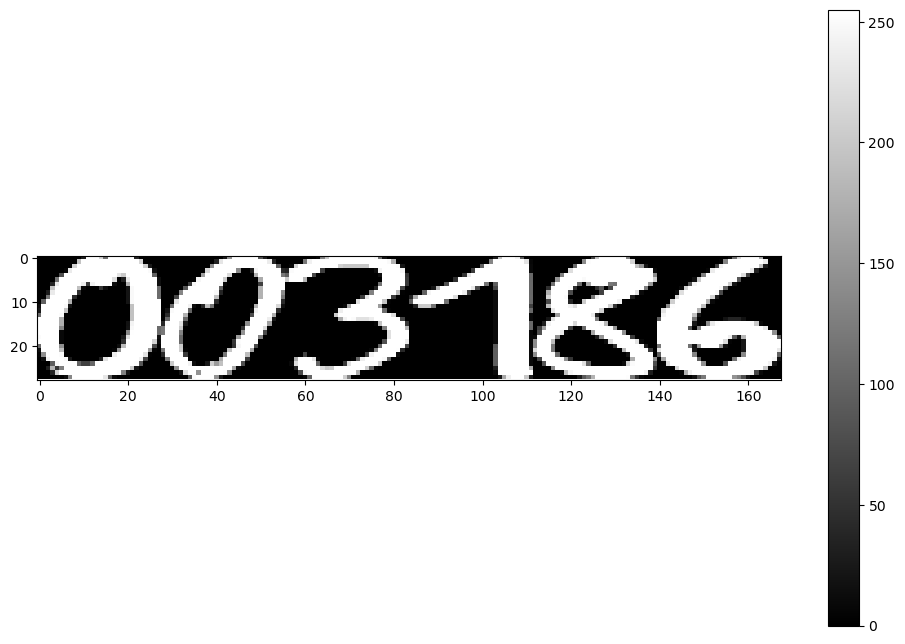

In [59]:
plt.imshow(
    skimage.util.montage(
        [x.reshape(mnist_target_shape) for x in X_test],
        grid_shape=(1, 6)
    ),
    cmap='gray'
)
plt.colorbar();

In [54]:
# true labels for our test images in the `digits` list
y_test = np.array([0, 0, 3, 1, 8, 6])
y_test

array([0, 0, 3, 1, 8, 6])

In [55]:
# perform the classification
y_pred = knn.predict(X_test)
y_pred

array([0, 7, 1, 0, 3, 6])

In [56]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.3333333333333333

In [60]:
# we can obtain the distances and indicies of the corresponding samples in the training data
mnist_dists, mnist_neighbors = knn.kneighbors(X_test, n_neighbors=10)
mnist_dists.shape, mnist_neighbors.shape

((6, 10), (6, 10))

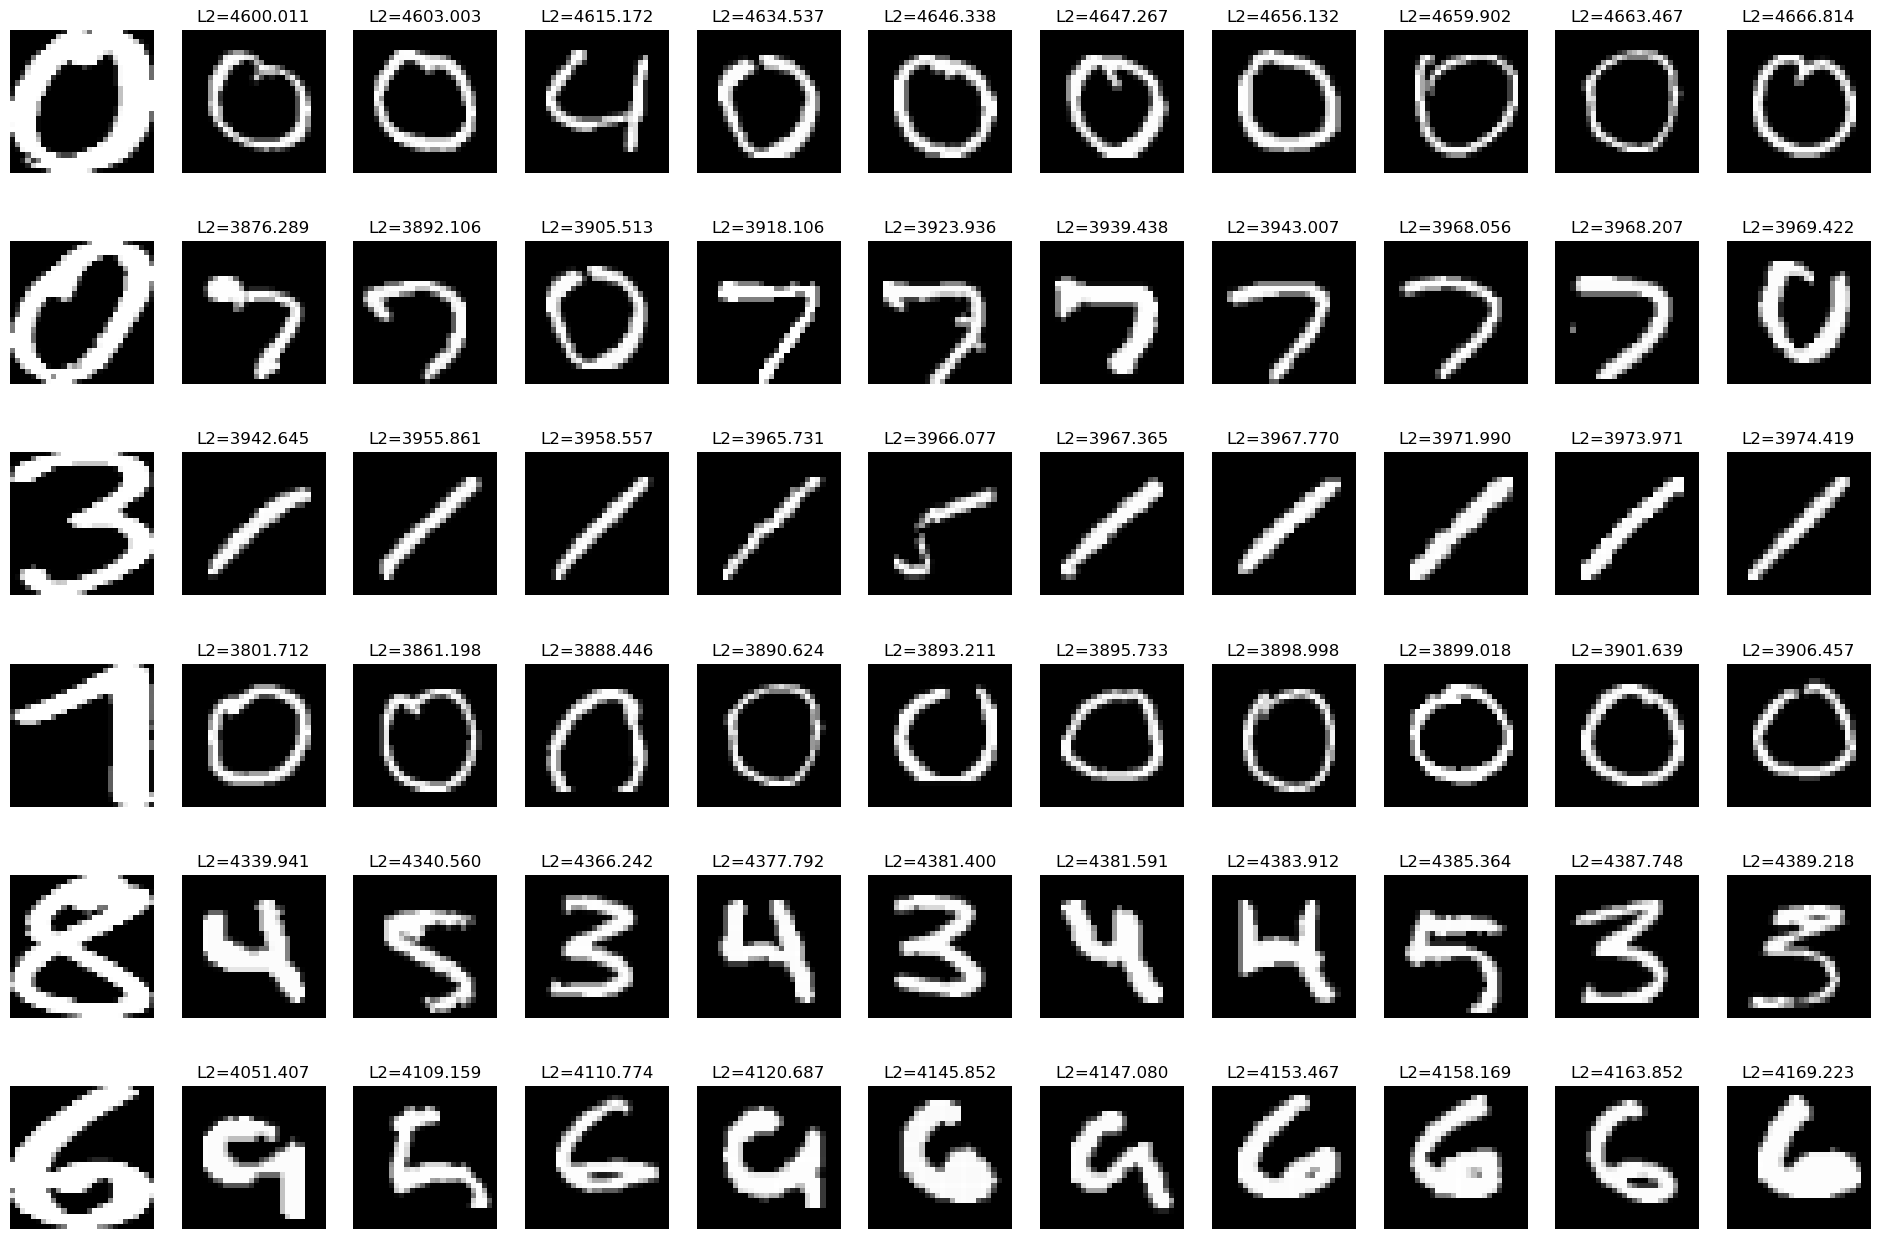

In [61]:
plt.figure(figsize=(24, 16))

for i in range(len(digits)):
    plt.subplot(len(digits), 1 + mnist_neighbors.shape[1], i * (1 + mnist_neighbors.shape[1]) + 1)
    plt.imshow(X_test[i].reshape(*mnist_target_shape), cmap='gray')
    plt.axis('off')
    
    for j, d in enumerate(mnist_dists[i]):
        plt.subplot(len(digits), 1 + mnist_neighbors.shape[1], i * (1 + mnist_neighbors.shape[1]) + j + 2)
        plt.imshow(X_train[mnist_neighbors[i, j]].reshape(*mnist_target_shape), cmap='gray')
        plt.title(f'L2={d:.3f}')
        plt.axis('off')

# Task 2 (optional): Try different distance metrics

C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


float64 (6, 784) 0.0 255.0
Accuracy: 0.3333333333333333


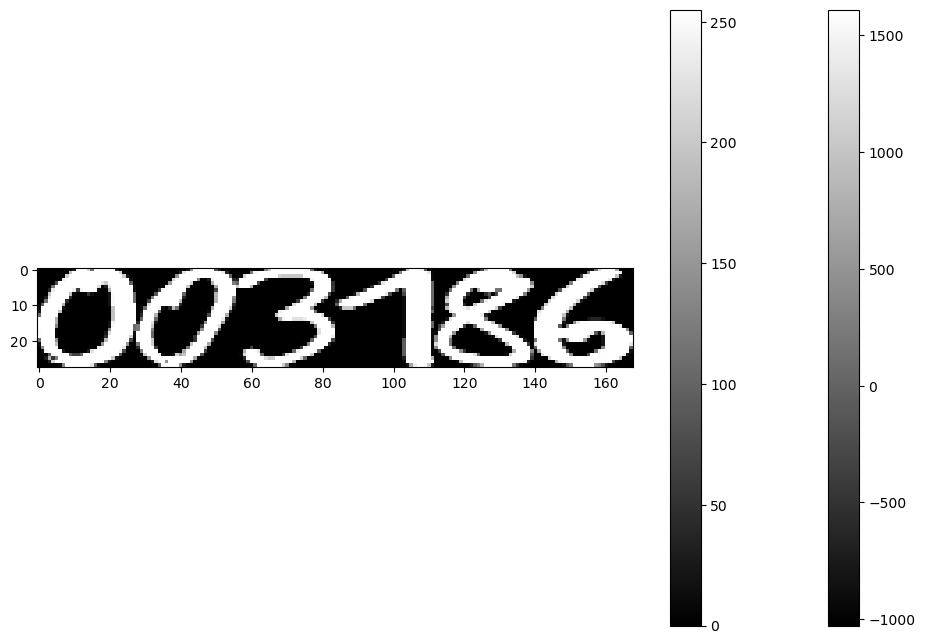

In [58]:
# since images are actually binary-like, you can try e.g. minkowski distance instead of the euclidean one
from sklearn.decomposition import PCA
sklearn.__version__
data = sklearn.datasets.fetch_openml(name='mnist_784')
data.keys()

X_train = data['data'] if isinstance(data['data'], np.ndarray) else data['data'].to_numpy()
y_train = data['target'] if isinstance(data['target'], np.ndarray) else data['target'].to_numpy().astype(int)

pca = PCA(n_components=100)  # You can experiment with the number of components
X_train_pca = pca.fit_transform(X_train)

mnist_target_shape = 28, 28
X_train_pca.dtype, X_train_pca.shape, X_train_pca.min(), X_train_pca.max()
y_train.dtype, y_train.shape, y_train.min(), y_train.max()

plt.imshow(
    skimage.util.montage(
        np.concatenate([
            np.random.default_rng().choice(X_train_pca[y_train==i], size=10, replace=False).reshape(-1, 10, 10)
            for i in range(10)
        ])
    ),
    cmap='gray'
)
plt.colorbar();
p_value = 3

knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', p=p_value)
knn.fit(X_train_pca, y_train)

mnist_target_shape = (28, 28)
preprocessed_digits = []
for digit in digits:
    resized_digit = cv2.resize(digit, mnist_target_shape)
    normalized_digit = (resized_digit - resized_digit.min()) / (resized_digit.max() - resized_digit.min()) * 255.0
    flattened_digit = normalized_digit.reshape(1, -1)
    preprocessed_digits.append(flattened_digit)
X_test = np.vstack(preprocessed_digits)
print(X_test.dtype, X_test.shape, X_test.min(), X_test.max())
plt.imshow(
    skimage.util.montage(
        [x.reshape(mnist_target_shape) for x in X_test],
        grid_shape=(1, 6)
    ),
    cmap='gray'
)
joblib.dump(pca, 'pca_model.pkl')
plt.colorbar();
y_test
y_pred
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Task 3: Discriminative classification uising support vector machine

In [59]:
from sklearn.datasets import fetch_openml
# Load the MNIST dataset
data = fetch_openml(name='mnist_784', version=1)
X = data['data']
y = data['target'].astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [60]:
# use `LinearSVC` classifier from the sklearn library
svc = LinearSVC()
joblib.dump(svc, 'linear_svc_model.pkl')
svc

LinearSVC()

In [61]:
# train the classifier using the `fit` function
# optimization process of classifier training might run for a few minutes or longer
svc.fit(X_train, y_train)

C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [62]:
# should be much faster than KNN classifier
y_pred = svc.predict(X_test)
y_pred

array([8, 4, 8, ..., 2, 7, 1])

In [63]:
sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8820714285714286


# Task 4 (optional): Write some numbers on a paper, take a picture using your phone and classify using classifier of your choice

In [62]:
# Load the MNIST dataset
data = datasets.fetch_openml(name='mnist_784')
X = data['data'] if isinstance(data['data'], np.ndarray) else data['data'].to_numpy()
y = data['target'] if isinstance(data['target'], np.ndarray) else data['target'].to_numpy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
svc = LinearSVC()
svc.fit(X_train_pca, y_train)
X_test_pca = pca.transform(X_test)
y_pred = svc.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

image = cv2.imread('data/Scanned.png', cv2.IMREAD_GRAYSCALE)
mnist_target_shape = (28, 28)
resized_image = cv2.resize(image, mnist_target_shape, interpolation=cv2.INTER_CUBIC)
normalized_image = (resized_image - resized_image.min()) / (resized_image.max() - resized_image.min()) * 255.0
flattened_image = normalized_image.reshape(1, -1)
flattened_image_pca = pca.transform(flattened_image)
predicted_class = svc.predict(flattened_image_pca)

print("Accuracy Score:", accuracy)
print("Predicted Class:", predicted_class[0])

joblib.dump(pca, 'pca_model.pkl')
joblib.dump(svc, 'linear_svc_model.pkl')

C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy Score: 0.8130714285714286
Predicted Class: 2


C:\Users\ANOOP\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
